# Filtragem de imagens e contornos com OpenCV

**Atenção**: Rode este notebook com `jupyter notebook` e não `jupyter lab`. A parte interativa requer que seja específico

Tópicos:
- [Equalização de histograma](#equalizacao)
- [Limiarização](#limiarizacao)
- [Deteção de cores com inRange](#inrange)
- [Componentes conexos e contornos](#compconexos)
- [Operações morfológicas](#morfologia)

Bibliografia: 

[Cap.5 - Computer Vision. Shapiro](https://courses.cs.washington.edu/courses/cse576/book/ch5.pdf)

[Cap.3 - Digital Image Processing. Gonzales / Woods](http://web.ipac.caltech.edu/staff/fmasci/home/astro_refs/Digital_Image_Processing_2ndEd.pdf)

In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
import sys
import math
print ("OpenCV Version : %s " % cv2.__version__)

from ipywidgets import widgets, interact, interactive, FloatSlider, IntSlider

import auxiliar as aux

if (sys.version_info > (3, 0)): 
    # Modo Python 3
    import importlib
    importlib.reload(aux) # Para garantir que o Jupyter sempre relê seu trabalho
else:
    # Modo Python 2
    reload(aux)



OpenCV Version : 4.5.1 
Este script não deve ser executado diretamente
Este script não deve ser executado diretamente


<div id="equalizacao"></div>

# Equalização de histograma

Vamos rever equalização e definir limiarização

In [2]:
rintin = cv2.imread("RinTinTin.jpg", cv2.IMREAD_GRAYSCALE)

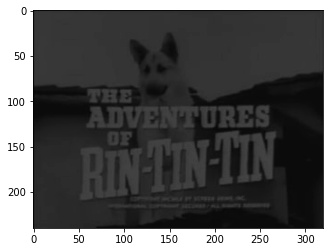

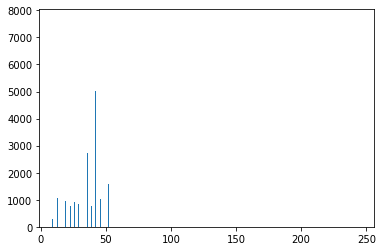

In [3]:
plt.imshow(rintin, cmap="Greys_r", vmin=0, vmax=255)
plt.show()
plt.hist(rintin.flatten(), bins=256)
plt.xlim([-1,256])
plt.show()


Pode-se, de forma prática, usar a função `cv2.equalizeHist` [para equalizar um histograma](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html)

In [4]:
rintin_eq = cv2.equalizeHist(rintin)

Verifiquemos o resultado

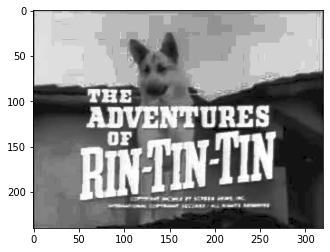

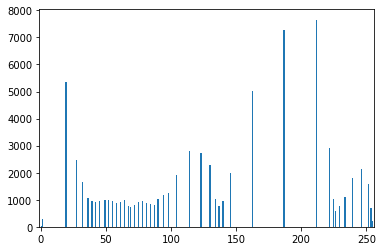

In [5]:
plt.imshow(rintin_eq, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.hist(rintin_eq.flatten(), bins=256)
plt.xlim([-1,256])
plt.show()

<div id="limiarizacao"></div>

## Limiarização

Para a limiarização, converte-se uma imagem em tons de cinza para uma imagem binária. A função `cv2.threshold` [é capaz de fazê-lo](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)

In [6]:
ret,limiarizada = cv2.threshold(rintin_eq,thresh=120,maxval=255,type=cv2.THRESH_BINARY)


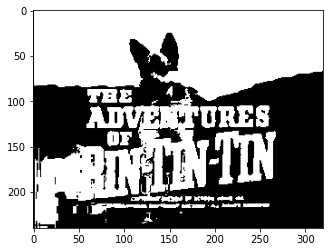

In [7]:
plt.imshow(limiarizada, cmap="gray")


<div id="filtragem"></div>

<div id="inrange"></div>

# Deteção de cores com inRange

O espaço de cores HSV é nosso amigo

![](https://upload.wikimedia.org/wikipedia/commons/8/8f/HSV_cylinder.jpg)

Imagem "linkada" do Wikipedia 

In [8]:
img_color = cv2.imread("hall_box_battery1.jpg")
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)


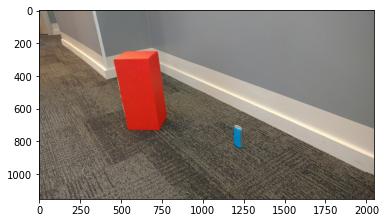

In [9]:
plt.imshow(img_rgb)

In [10]:
colorpicker = widgets.ColorPicker(
    concise=False,
    description='Escolha uma cor',
    value='#ff0e00',
    disabled=False
)

In [11]:
colorpicker

ColorPicker(value='#ff0e00', description='Escolha uma cor')

In [12]:
hsv1, hsv2 = aux.ranges(colorpicker.value)

In [13]:
hsv1

array([ 0, 50, 50], dtype=uint8)

In [14]:
hsv2

array([ 10, 255, 255], dtype=uint8)

In [15]:
mask = cv2.inRange(img_hsv, hsv1, hsv2)    

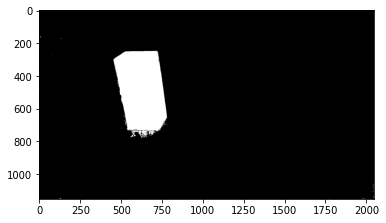

In [16]:
plt.imshow(mask, cmap="gray")

In [17]:
selecao = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

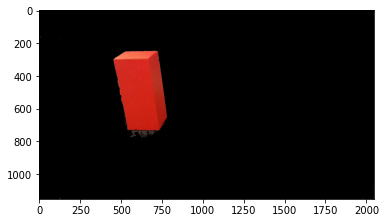

In [18]:
selecao = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
plt.imshow(selecao)


<div id="compconexos"></div>

## Componentes conexos e contornos

E se tivéssemos mais de um objeto vermelho na imagem? Como faríamos para identificá-los?

Fonte das imagens: [http://time.com/4299724/coca-cola-diet-coke-redesign/](http://time.com/4299724/coca-cola-diet-coke-redesign/)

In [19]:
coke = cv2.imread("coke-cans.jpg")
coke_rgb= cv2.cvtColor(coke, cv2.COLOR_BGR2RGB)
coke_hsv= cv2.cvtColor(coke, cv2.COLOR_BGR2HSV)

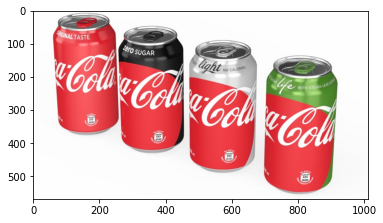

In [20]:
plt.imshow(coke_rgb)

Para detectar vermelho em HSV, não se esquecer de seelcionar a faixa inferior e a superior do canal H

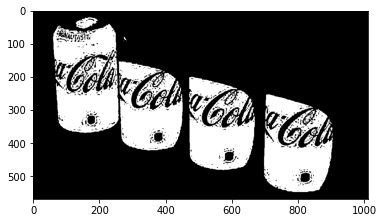

In [21]:
cor_menor1 = np.array([172, 50, 50])
cor_maior1 = np.array([180, 255, 255])
mask_coke1 = cv2.inRange(coke_hsv, cor_menor1, cor_maior1)

plt.imshow(mask_coke1, cmap='gray')


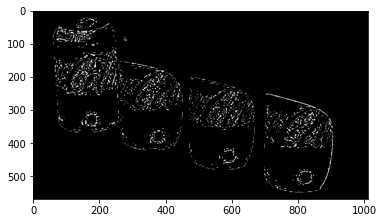

In [22]:
cor_menor2 = np.array([0, 50, 50])
cor_maior2 = np.array([8, 255, 255])
mask_coke2 = cv2.inRange(coke_hsv, cor_menor2, cor_maior2)

plt.imshow(mask_coke2, cmap='gray')


In [23]:
# Juntando as máscaras
mask_coke = cv2.bitwise_or(mask_coke1,mask_coke2)

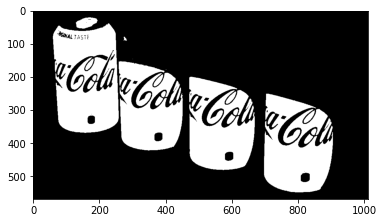

In [24]:
plt.imshow(mask_coke, cmap="gray", vmin=0, vmax=255)


Contorno - juntando componentes conexos

In [25]:
# Para OpenCV cv2 versão 3 use a linha abaixo:
#img_out, contornos, arvore = cv2.findContours(segmentado_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
contornos, arvore = cv2.findContours(mask_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
len(contornos)

111

In [26]:
contornos_img = coke_rgb.copy()
cv2.drawContours(contornos_img, contornos, -1, [0, 0, 255], 3);

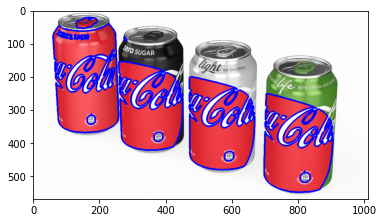

In [27]:
plt.imshow(contornos_img)

Maior contorno

In [28]:
maior = None
maior_area = 0
for c in contornos:
    area = cv2.contourArea(c)
    if area > maior_area:
        maior_area = area
        maior = c



In [29]:
cv2.drawContours(contornos_img, [maior], -1, [0, 255, 255], 5);


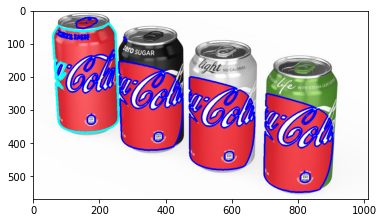

In [30]:
plt.imshow(contornos_img)

<div id="hough"></div>